# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import os
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig

# Set config

In [3]:
llm_config = LLMConfig(
    vocab_size=512,
    context_size=256,
    dim_emb=512,
    num_layers=4,
    num_heads=4
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    batch_size=128,
    learning_rate=1e-4,
    max_steps=100,
    log_frequency=1
)

# Prepare tokenizer and dataset


In [4]:
input_file = "../data/shakespeare/alllines.txt"
output_path = "../data/shakespeare"

tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file) or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size, tokenizer_model_file)

tokenizer = Tokenizer(tokenizer_model_file)

In [5]:
sentence = "The role of the tokenizer is to build a mapping between subwords and token indices"
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁r', 'o', 'le', '▁of', '▁the', '▁to', 'ke', 'n', 'i', 'z', 'er', '▁is', '▁to', '▁b', 'u', 'il', 'd', '▁a', '▁ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁', 's', 'u', 'b', 'w', 'or', 'd', 's', '▁and', '▁to', 'ke', 'n', '▁in', 'd', 'ice', 's']


In [6]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

ds_train.get_batch(batch_size=1)

(tensor([[  4, 289,  12, 184,  22,   6,  36,  13,  13, 208,  10, 306,   4,  12,
           43,  15, 160, 205,   8, 169,   4,  33, 507,   4,   6, 291, 196,   4,
           11,   6,   7, 126,  26,  12, 202, 277,   4,  11, 430,  12, 124,  19,
          235,   7,  31,  27,  39,  58, 109, 330,   9,  48,   4,  50, 177, 126,
            6, 266,   4,  50,   6, 163, 208,  18,  26, 312,  24,  29,  16, 134,
           18,   4, 285,  72,  97, 199,   4,   6,   5,  25,  13, 121, 271,  39,
          455,  27,  84, 131,  30,  35,   4, 203,  84, 131,  30,  35,   4, 194,
           11,   6,  36,  56,  30,   4,  20,  84, 234,  63,   9,  91,  31,  35,
            4, 203,  84,  91,  31,  35,   4, 430,  20, 430,  27,  20, 480, 339,
           35,   4, 346, 365,   6, 291,  16,  37,  31,  53,   7,   4,  87,  28,
           78,  35,  40, 112, 134, 322,  71, 168, 123,  62,  70,  32, 107,  45,
           88,   4,  19, 511,  13,  23,  74,  11,   6,  37, 165,   9,   5,  24,
           71, 300,  55,  11, 351,   5, 

# Define model


In [7]:
model = LLM(
    vocab_size=llm_config.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
)

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,d}")

print(model)

total params: 8,927,744
learnable params: 8,927,744
LLM(
  (token_embedding): Embedding(512, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=512, out_features=512, bias=False)
        (projection_key): Linear(in_features=512, out_features=512, bias=False)
        (projection_value): Linear(in_features=512, out_features=512, bias=False)
        (projection_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
          (3): Linear(in_features=512, out_features=

# Train model


In [8]:
loss_history = train(
    model,
    ds_train,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    log_every=train_config.log_frequency,
)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9978e-04.
Adjusting learning rate of group 0 to 9.9911e-04.
Adjusting learning rate of group 0 to 9.9800e-04.
Adjusting learning rate of group 0 to 9.9645e-04.
Adjusting learning rate of group 0 to 9.9446e-04.
Adjusting learning rate of group 0 to 9.9203e-04.
Adjusting learning rate of group 0 to 9.8916e-04.
Adjusting learning rate of group 0 to 9.8586e-04.
Adjusting learning rate of group 0 to 9.8213e-04.
Adjusting learning rate of group 0 to 9.7798e-04.
Adjusting learning rate of group 0 to 9.7340e-04.
Adjusting learning rate of group 0 to 9.6840e-04.
Adjusting learning rate of group 0 to 9.6299e-04.
Adjusting learning rate of group 0 to 9.5717e-04.
Adjusting learning rate of group 0 to 9.5095e-04.
Adjusting learning rate of group 0 to 9.4434e-04.
Adjusting learning rate of group 0 to 9.3733e-04.
Adjusting learning rate of group 0 to 9.2995e-04.
Adjusting learning rate of group 0 to 9.2219e-04.


Text(0, 0.5, 'cross entropy loss')

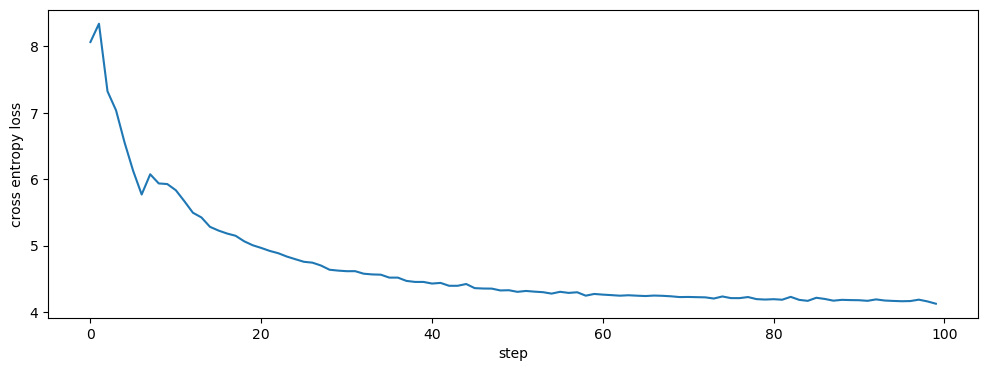

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")

# Play around

In [10]:
# empty prompt to generate random stuff
prompt = torch.zeros((1, llm_config.context_size), dtype=torch.int32)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

"lput, ass. Oe, too giveings of this, how their Dend agains, Haventity, Belier't, I war to ut from this coes what torull"

In [11]:
prompt = tokenizer.encode("I took an arrow to the knee, ", beg_of_string=True, pad_seq=True, seq_len=llm_config.context_size).view(1, -1)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

"I took an arrow to the knee, For by device agains the fleenters should roughtuncurk, even I can keepsar, sir forech? perer ship thatt them to the fear 'tis And think. Exeunt"